# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [23]:
!pip install datasets==3.3.2

### Import Packages

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, Qwen2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [25]:
!nvidia-smi

Sat Apr  5 11:11:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             33W /  250W |     843MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [26]:
set_seed(1126)

# Prepare Data

### Define Dataset

In [27]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [28]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Visualization

In [29]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

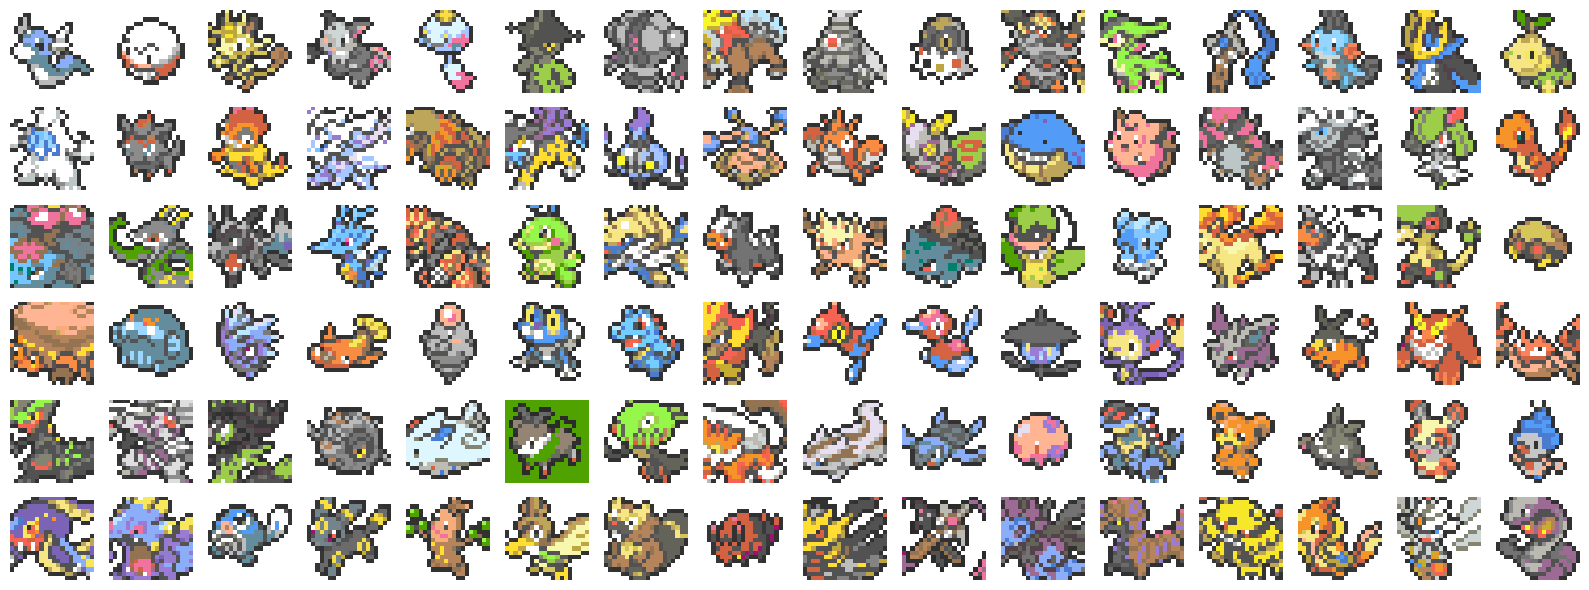

In [30]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

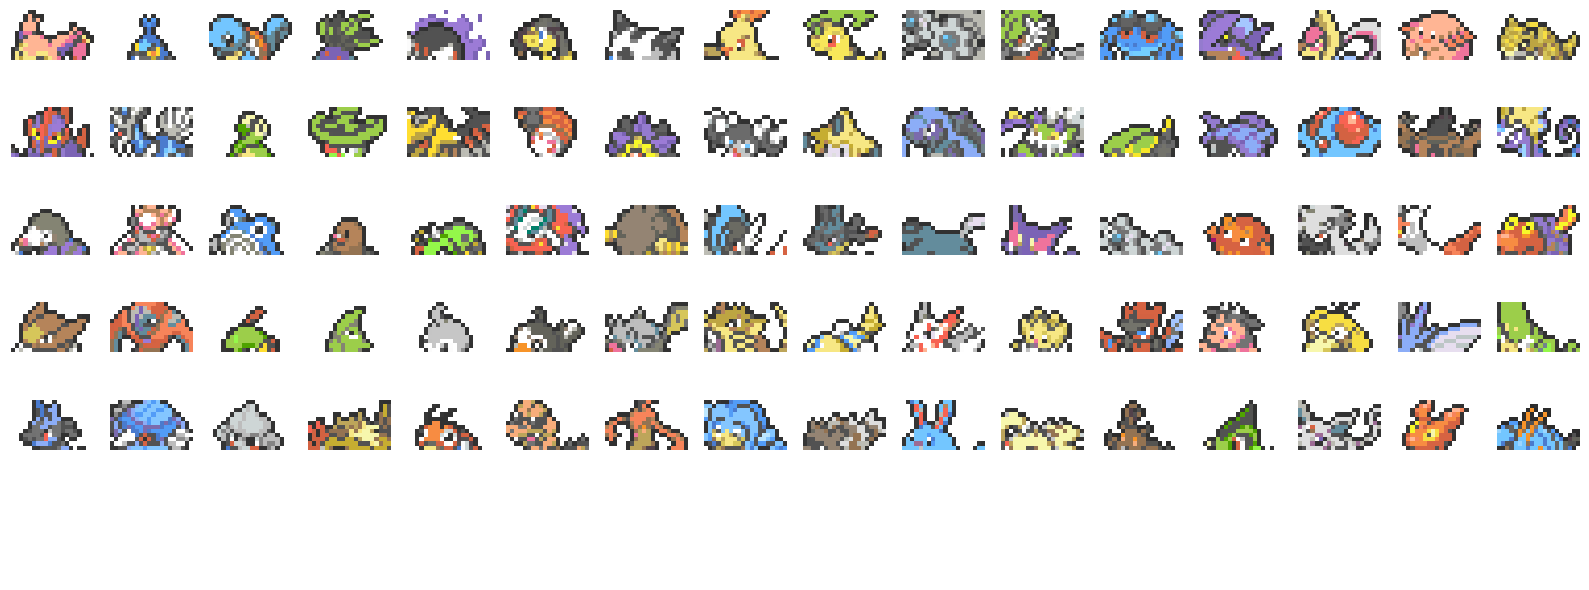

In [31]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [32]:
# Define qwen2 model configuration as a dictionary
qwen2_config = {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": None,
  "eos_token_id": None,
  "hidden_act": "silu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 256,
  "max_position_embeddings": 400,
  "max_window_layers": 28,
  "model_type": "qwen2",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "num_key_value_heads": 4,
  "vocab_size": num_classes
}
# {
#     'vocab_size': num_classes,
#     'hidden_size': 128,
#     'intermediate_size': 512,
#     'num_hidden_layers': 12,
#     'num_attention_heads': 2,
#     'num_key_value_heads': 8,
#     'hidden_act': 'gelu',
#     'max_position_embeddings': 400,
#     'initializer_range': 0.02,
#     'rms_norm_eps': 1e-12,
#     'use_cache': True,
#     'tie_word_embeddings': True,
#     'use_sliding_window': True,
#     'sliding_window': 20,
#     'max_window_layers': 6,
#     'attention_dropout': 0.1,
# }

# Load qwen2 model configuration from dictionary
config = Qwen2Config.from_dict(qwen2_config)

### Load Model

In [33]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 128)
    (layers): ModuleList(
      (0-11): 12 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (o_proj): Linear(in_features=128, out_features=128, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=128, out_features=256, bias=False)
          (up_proj): Linear(in_features=128, out_features=256, bias=False)
          (down_proj): Linear(in_features=256, out_features=128, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((128,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((128,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((128,),

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [34]:
# Training Parameters
epochs = 150                                      # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [35]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [36]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 1/150, Loss: 3.6784


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 1/150, Reconstruction Accuracy: 0.4032
Model saved at checkpoints/best_model.pth (Loss: 3.6784, Epoch: 1)


Training Epoch 2/150: 100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 2/150, Loss: 3.0969


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 2/150, Reconstruction Accuracy: 0.3965
Model saved at checkpoints/best_model.pth (Loss: 3.0969, Epoch: 2)


Training Epoch 3/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 3/150, Loss: 2.8596


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 3/150, Reconstruction Accuracy: 0.4055
Model saved at checkpoints/best_model.pth (Loss: 2.8596, Epoch: 3)


Training Epoch 4/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 4/150, Loss: 2.6617


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 4/150, Reconstruction Accuracy: 0.3813
Model saved at checkpoints/best_model.pth (Loss: 2.6617, Epoch: 4)


Training Epoch 5/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 5/150, Loss: 2.3831


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 5/150, Reconstruction Accuracy: 0.3597
Model saved at checkpoints/best_model.pth (Loss: 2.3831, Epoch: 5)


Training Epoch 6/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 6/150, Loss: 2.1472


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 6/150, Reconstruction Accuracy: 0.3535
Model saved at checkpoints/best_model.pth (Loss: 2.1472, Epoch: 6)


Training Epoch 7/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 7/150, Loss: 1.9338


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 7/150, Reconstruction Accuracy: 0.3499
Model saved at checkpoints/best_model.pth (Loss: 1.9338, Epoch: 7)


Training Epoch 8/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 8/150, Loss: 1.7619


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 8/150, Reconstruction Accuracy: 0.3569
Model saved at checkpoints/best_model.pth (Loss: 1.7619, Epoch: 8)


Training Epoch 9/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 9/150, Loss: 1.6376


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 9/150, Reconstruction Accuracy: 0.3398
Model saved at checkpoints/best_model.pth (Loss: 1.6376, Epoch: 9)


Training Epoch 10/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 10/150, Loss: 1.5626


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 10/150, Reconstruction Accuracy: 0.3629
Model saved at checkpoints/best_model.pth (Loss: 1.5626, Epoch: 10)


Training Epoch 11/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 11/150, Loss: 1.5008


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 11/150, Reconstruction Accuracy: 0.3281
Model saved at checkpoints/best_model.pth (Loss: 1.5008, Epoch: 11)


Training Epoch 12/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 12/150, Loss: 1.4530


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 12/150, Reconstruction Accuracy: 0.2963
Model saved at checkpoints/best_model.pth (Loss: 1.4530, Epoch: 12)


Training Epoch 13/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 13/150, Loss: 1.3983


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 13/150, Reconstruction Accuracy: 0.3659
Model saved at checkpoints/best_model.pth (Loss: 1.3983, Epoch: 13)


Training Epoch 14/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 14/150, Loss: 1.3521


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 14/150, Reconstruction Accuracy: 0.3678
Model saved at checkpoints/best_model.pth (Loss: 1.3521, Epoch: 14)


Training Epoch 15/150: 100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch 15/150, Loss: 1.3197


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 15/150, Reconstruction Accuracy: 0.3800
Model saved at checkpoints/best_model.pth (Loss: 1.3197, Epoch: 15)


Training Epoch 16/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 16/150, Loss: 1.2818


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 16/150, Reconstruction Accuracy: 0.3380
Model saved at checkpoints/best_model.pth (Loss: 1.2818, Epoch: 16)


Training Epoch 17/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 17/150, Loss: 1.2430


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 17/150, Reconstruction Accuracy: 0.3773
Model saved at checkpoints/best_model.pth (Loss: 1.2430, Epoch: 17)


Training Epoch 18/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 18/150, Loss: 1.2208


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 18/150, Reconstruction Accuracy: 0.3663
Model saved at checkpoints/best_model.pth (Loss: 1.2208, Epoch: 18)


Training Epoch 19/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 19/150, Loss: 1.1837


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 19/150, Reconstruction Accuracy: 0.3563
Model saved at checkpoints/best_model.pth (Loss: 1.1837, Epoch: 19)


Training Epoch 20/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 20/150, Loss: 1.1575


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 20/150, Reconstruction Accuracy: 0.3634
Model saved at checkpoints/best_model.pth (Loss: 1.1575, Epoch: 20)


Training Epoch 21/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 21/150, Loss: 1.1249


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 21/150, Reconstruction Accuracy: 0.3596
Model saved at checkpoints/best_model.pth (Loss: 1.1249, Epoch: 21)


Training Epoch 22/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 22/150, Loss: 1.1019


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 22/150, Reconstruction Accuracy: 0.3456
Model saved at checkpoints/best_model.pth (Loss: 1.1019, Epoch: 22)


Training Epoch 23/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 23/150, Loss: 1.0789


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 23/150, Reconstruction Accuracy: 0.3495
Model saved at checkpoints/best_model.pth (Loss: 1.0789, Epoch: 23)


Training Epoch 24/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 24/150, Loss: 1.0331


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 24/150, Reconstruction Accuracy: 0.3524
Model saved at checkpoints/best_model.pth (Loss: 1.0331, Epoch: 24)


Training Epoch 25/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 25/150, Loss: 0.9916


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 25/150, Reconstruction Accuracy: 0.3658
Model saved at checkpoints/best_model.pth (Loss: 0.9916, Epoch: 25)


Training Epoch 26/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 26/150, Loss: 0.9586


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 26/150, Reconstruction Accuracy: 0.3842
Model saved at checkpoints/best_model.pth (Loss: 0.9586, Epoch: 26)


Training Epoch 27/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 27/150, Loss: 0.9290


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 27/150, Reconstruction Accuracy: 0.3325
Model saved at checkpoints/best_model.pth (Loss: 0.9290, Epoch: 27)


Training Epoch 28/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 28/150, Loss: 0.8943


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 28/150, Reconstruction Accuracy: 0.3723
Model saved at checkpoints/best_model.pth (Loss: 0.8943, Epoch: 28)


Training Epoch 29/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 29/150, Loss: 0.8544


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 29/150, Reconstruction Accuracy: 0.3719
Model saved at checkpoints/best_model.pth (Loss: 0.8544, Epoch: 29)


Training Epoch 30/150: 100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 30/150, Loss: 0.8237


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch 30/150, Reconstruction Accuracy: 0.3407
Model saved at checkpoints/best_model.pth (Loss: 0.8237, Epoch: 30)


Training Epoch 31/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 31/150, Loss: 0.7919


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 31/150, Reconstruction Accuracy: 0.3317
Model saved at checkpoints/best_model.pth (Loss: 0.7919, Epoch: 31)


Training Epoch 32/150: 100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 32/150, Loss: 0.7619


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Epoch 32/150, Reconstruction Accuracy: 0.3498
Model saved at checkpoints/best_model.pth (Loss: 0.7619, Epoch: 32)


Training Epoch 33/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 33/150, Loss: 0.7060


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 33/150, Reconstruction Accuracy: 0.3316
Model saved at checkpoints/best_model.pth (Loss: 0.7060, Epoch: 33)


Training Epoch 34/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 34/150, Loss: 0.6954


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 34/150, Reconstruction Accuracy: 0.3550
Model saved at checkpoints/best_model.pth (Loss: 0.6954, Epoch: 34)


Training Epoch 35/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 35/150, Loss: 0.6473


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Epoch 35/150, Reconstruction Accuracy: 0.3672
Model saved at checkpoints/best_model.pth (Loss: 0.6473, Epoch: 35)


Training Epoch 36/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 36/150, Loss: 0.5930


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 36/150, Reconstruction Accuracy: 0.3676
Model saved at checkpoints/best_model.pth (Loss: 0.5930, Epoch: 36)


Training Epoch 37/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 37/150, Loss: 0.5656


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


Epoch 37/150, Reconstruction Accuracy: 0.3480
Model saved at checkpoints/best_model.pth (Loss: 0.5656, Epoch: 37)


Training Epoch 38/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 38/150, Loss: 0.5197


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 38/150, Reconstruction Accuracy: 0.3740
Model saved at checkpoints/best_model.pth (Loss: 0.5197, Epoch: 38)


Training Epoch 39/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 39/150, Loss: 0.4923


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 39/150, Reconstruction Accuracy: 0.3472
Model saved at checkpoints/best_model.pth (Loss: 0.4923, Epoch: 39)


Training Epoch 40/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 40/150, Loss: 0.4860


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 40/150, Reconstruction Accuracy: 0.3512
Model saved at checkpoints/best_model.pth (Loss: 0.4860, Epoch: 40)


Training Epoch 41/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 41/150, Loss: 0.4371


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 41/150, Reconstruction Accuracy: 0.3392
Model saved at checkpoints/best_model.pth (Loss: 0.4371, Epoch: 41)


Training Epoch 42/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 42/150, Loss: 0.4052


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 42/150, Reconstruction Accuracy: 0.3320
Model saved at checkpoints/best_model.pth (Loss: 0.4052, Epoch: 42)


Training Epoch 43/150: 100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 43/150, Loss: 0.3865


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 43/150, Reconstruction Accuracy: 0.3628
Model saved at checkpoints/best_model.pth (Loss: 0.3865, Epoch: 43)


Training Epoch 44/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 44/150, Loss: 0.3664


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 44/150, Reconstruction Accuracy: 0.3568
Model saved at checkpoints/best_model.pth (Loss: 0.3664, Epoch: 44)


Training Epoch 45/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 45/150, Loss: 0.3400


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 45/150, Reconstruction Accuracy: 0.3520
Model saved at checkpoints/best_model.pth (Loss: 0.3400, Epoch: 45)


Training Epoch 46/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 46/150, Loss: 0.3140


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 46/150, Reconstruction Accuracy: 0.3492
Model saved at checkpoints/best_model.pth (Loss: 0.3140, Epoch: 46)


Training Epoch 47/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 47/150, Loss: 0.3110


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 47/150, Reconstruction Accuracy: 0.3352
Model saved at checkpoints/best_model.pth (Loss: 0.3110, Epoch: 47)


Training Epoch 48/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 48/150, Loss: 0.2706


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 48/150, Reconstruction Accuracy: 0.3295
Model saved at checkpoints/best_model.pth (Loss: 0.2706, Epoch: 48)


Training Epoch 49/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 49/150, Loss: 0.2285


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Epoch 49/150, Reconstruction Accuracy: 0.3478
Model saved at checkpoints/best_model.pth (Loss: 0.2285, Epoch: 49)


Training Epoch 50/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 50/150, Loss: 0.2117


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 50/150, Reconstruction Accuracy: 0.3693
Model saved at checkpoints/best_model.pth (Loss: 0.2117, Epoch: 50)


Training Epoch 51/150: 100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 51/150, Loss: 0.2103


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 51/150, Reconstruction Accuracy: 0.3583
Model saved at checkpoints/best_model.pth (Loss: 0.2103, Epoch: 51)


Training Epoch 52/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 52/150, Loss: 0.2037


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 52/150, Reconstruction Accuracy: 0.3602
Model saved at checkpoints/best_model.pth (Loss: 0.2037, Epoch: 52)


Training Epoch 53/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 53/150, Loss: 0.1978


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 53/150, Reconstruction Accuracy: 0.3578
Model saved at checkpoints/best_model.pth (Loss: 0.1978, Epoch: 53)


Training Epoch 54/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 54/150, Loss: 0.1921


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 54/150, Reconstruction Accuracy: 0.3530
Model saved at checkpoints/best_model.pth (Loss: 0.1921, Epoch: 54)


Training Epoch 55/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 55/150, Loss: 0.1696


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 55/150, Reconstruction Accuracy: 0.3398
Model saved at checkpoints/best_model.pth (Loss: 0.1696, Epoch: 55)


Training Epoch 56/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 56/150, Loss: 0.1526


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 56/150, Reconstruction Accuracy: 0.3542
Model saved at checkpoints/best_model.pth (Loss: 0.1526, Epoch: 56)


Training Epoch 57/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 57/150, Loss: 0.1409


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 57/150, Reconstruction Accuracy: 0.3525
Model saved at checkpoints/best_model.pth (Loss: 0.1409, Epoch: 57)


Training Epoch 58/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 58/150, Loss: 0.1336


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 58/150, Reconstruction Accuracy: 0.3470
Model saved at checkpoints/best_model.pth (Loss: 0.1336, Epoch: 58)


Training Epoch 59/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 59/150, Loss: 0.1218


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 59/150, Reconstruction Accuracy: 0.3741
Model saved at checkpoints/best_model.pth (Loss: 0.1218, Epoch: 59)


Training Epoch 60/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 60/150, Loss: 0.1180


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 60/150, Reconstruction Accuracy: 0.3409
Model saved at checkpoints/best_model.pth (Loss: 0.1180, Epoch: 60)


Training Epoch 61/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 61/150, Loss: 0.1084


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 61/150, Reconstruction Accuracy: 0.3491
Model saved at checkpoints/best_model.pth (Loss: 0.1084, Epoch: 61)


Training Epoch 62/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 62/150, Loss: 0.1043


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 62/150, Reconstruction Accuracy: 0.3303
Model saved at checkpoints/best_model.pth (Loss: 0.1043, Epoch: 62)


Training Epoch 63/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 63/150, Loss: 0.1041


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 63/150, Reconstruction Accuracy: 0.3286
Model saved at checkpoints/best_model.pth (Loss: 0.1041, Epoch: 63)


Training Epoch 64/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 64/150, Loss: 0.0956


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 64/150, Reconstruction Accuracy: 0.3385
Model saved at checkpoints/best_model.pth (Loss: 0.0956, Epoch: 64)


Training Epoch 65/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 65/150, Loss: 0.1017


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 65/150, Reconstruction Accuracy: 0.3402


Training Epoch 66/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 66/150, Loss: 0.1011


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 66/150, Reconstruction Accuracy: 0.3425


Training Epoch 67/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 67/150, Loss: 0.1064


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 67/150, Reconstruction Accuracy: 0.3614


Training Epoch 68/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 68/150, Loss: 0.1120


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 68/150, Reconstruction Accuracy: 0.3623


Training Epoch 69/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 69/150, Loss: 0.1105


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 69/150, Reconstruction Accuracy: 0.3581


Training Epoch 70/150: 100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 70/150, Loss: 0.1026


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 70/150, Reconstruction Accuracy: 0.3388


Training Epoch 71/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 71/150, Loss: 0.0957


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 71/150, Reconstruction Accuracy: 0.3438


Training Epoch 72/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 72/150, Loss: 0.0894


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 72/150, Reconstruction Accuracy: 0.3488
Model saved at checkpoints/best_model.pth (Loss: 0.0894, Epoch: 72)


Training Epoch 73/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 73/150, Loss: 0.0901


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 73/150, Reconstruction Accuracy: 0.3570


Training Epoch 74/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 74/150, Loss: 0.0858


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 74/150, Reconstruction Accuracy: 0.3242
Model saved at checkpoints/best_model.pth (Loss: 0.0858, Epoch: 74)


Training Epoch 75/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 75/150, Loss: 0.0836


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 75/150, Reconstruction Accuracy: 0.3625
Model saved at checkpoints/best_model.pth (Loss: 0.0836, Epoch: 75)


Training Epoch 76/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 76/150, Loss: 0.0766


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 76/150, Reconstruction Accuracy: 0.3371
Model saved at checkpoints/best_model.pth (Loss: 0.0766, Epoch: 76)


Training Epoch 77/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 77/150, Loss: 0.0740


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 77/150, Reconstruction Accuracy: 0.3410
Model saved at checkpoints/best_model.pth (Loss: 0.0740, Epoch: 77)


Training Epoch 78/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 78/150, Loss: 0.0749


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 78/150, Reconstruction Accuracy: 0.3400


Training Epoch 79/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 79/150, Loss: 0.0802


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 79/150, Reconstruction Accuracy: 0.3368


Training Epoch 80/150: 100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 80/150, Loss: 0.0837


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 80/150, Reconstruction Accuracy: 0.3342


Training Epoch 81/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 81/150, Loss: 0.0937


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 81/150, Reconstruction Accuracy: 0.3473


Training Epoch 82/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 82/150, Loss: 0.1072


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 82/150, Reconstruction Accuracy: 0.3273


Training Epoch 83/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 83/150, Loss: 0.1231


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 83/150, Reconstruction Accuracy: 0.3166


Training Epoch 84/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 84/150, Loss: 0.1524


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 84/150, Reconstruction Accuracy: 0.3508


Training Epoch 85/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 85/150, Loss: 0.1544


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Epoch 85/150, Reconstruction Accuracy: 0.3281


Training Epoch 86/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 86/150, Loss: 0.1324


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 86/150, Reconstruction Accuracy: 0.3420


Training Epoch 87/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 87/150, Loss: 0.1045


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 87/150, Reconstruction Accuracy: 0.3439


Training Epoch 88/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 88/150, Loss: 0.0771


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 88/150, Reconstruction Accuracy: 0.3347


Training Epoch 89/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 89/150, Loss: 0.0603


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 89/150, Reconstruction Accuracy: 0.3527
Model saved at checkpoints/best_model.pth (Loss: 0.0603, Epoch: 89)


Training Epoch 90/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 90/150, Loss: 0.0436


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 90/150, Reconstruction Accuracy: 0.3234
Model saved at checkpoints/best_model.pth (Loss: 0.0436, Epoch: 90)


Training Epoch 91/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 91/150, Loss: 0.0357


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 91/150, Reconstruction Accuracy: 0.3503
Model saved at checkpoints/best_model.pth (Loss: 0.0357, Epoch: 91)


Training Epoch 92/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 92/150, Loss: 0.0327


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 92/150, Reconstruction Accuracy: 0.3553
Model saved at checkpoints/best_model.pth (Loss: 0.0327, Epoch: 92)


Training Epoch 93/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 93/150, Loss: 0.0316


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 93/150, Reconstruction Accuracy: 0.3620
Model saved at checkpoints/best_model.pth (Loss: 0.0316, Epoch: 93)


Training Epoch 94/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 94/150, Loss: 0.0292


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 94/150, Reconstruction Accuracy: 0.3429
Model saved at checkpoints/best_model.pth (Loss: 0.0292, Epoch: 94)


Training Epoch 95/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 95/150, Loss: 0.0281


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 95/150, Reconstruction Accuracy: 0.3571
Model saved at checkpoints/best_model.pth (Loss: 0.0281, Epoch: 95)


Training Epoch 96/150: 100%|██████████| 40/40 [00:02<00:00, 13.91it/s]


Epoch 96/150, Loss: 0.0274


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 96/150, Reconstruction Accuracy: 0.3634
Model saved at checkpoints/best_model.pth (Loss: 0.0274, Epoch: 96)


Training Epoch 97/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 97/150, Loss: 0.0266


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 97/150, Reconstruction Accuracy: 0.3406
Model saved at checkpoints/best_model.pth (Loss: 0.0266, Epoch: 97)


Training Epoch 98/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 98/150, Loss: 0.0280


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 98/150, Reconstruction Accuracy: 0.3466


Training Epoch 99/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 99/150, Loss: 0.0271


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 99/150, Reconstruction Accuracy: 0.3457


Training Epoch 100/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 100/150, Loss: 0.0265


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 100/150, Reconstruction Accuracy: 0.3560
Model saved at checkpoints/best_model.pth (Loss: 0.0265, Epoch: 100)


Training Epoch 101/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 101/150, Loss: 0.0293


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 101/150, Reconstruction Accuracy: 0.3648


Training Epoch 102/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 102/150, Loss: 0.0332


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 102/150, Reconstruction Accuracy: 0.3574


Training Epoch 103/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 103/150, Loss: 0.0368


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 103/150, Reconstruction Accuracy: 0.3534


Training Epoch 104/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 104/150, Loss: 0.0536


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 104/150, Reconstruction Accuracy: 0.3324


Training Epoch 105/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 105/150, Loss: 0.0929


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 105/150, Reconstruction Accuracy: 0.3454


Training Epoch 106/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 106/150, Loss: 0.3007


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 106/150, Reconstruction Accuracy: 0.3050


Training Epoch 107/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 107/150, Loss: 0.5063


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 107/150, Reconstruction Accuracy: 0.3569


Training Epoch 108/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 108/150, Loss: 0.3151


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 108/150, Reconstruction Accuracy: 0.3338


Training Epoch 109/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 109/150, Loss: 0.1700


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 109/150, Reconstruction Accuracy: 0.3457


Training Epoch 110/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 110/150, Loss: 0.1037


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 110/150, Reconstruction Accuracy: 0.3573


Training Epoch 111/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 111/150, Loss: 0.0669


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 111/150, Reconstruction Accuracy: 0.3557


Training Epoch 112/150: 100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


Epoch 112/150, Loss: 0.0524


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Epoch 112/150, Reconstruction Accuracy: 0.3380


Training Epoch 113/150: 100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 113/150, Loss: 0.0393


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


Epoch 113/150, Reconstruction Accuracy: 0.3591


Training Epoch 114/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 114/150, Loss: 0.0324


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 114/150, Reconstruction Accuracy: 0.3477


Training Epoch 115/150: 100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


Epoch 115/150, Loss: 0.0295


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 115/150, Reconstruction Accuracy: 0.3730


Training Epoch 116/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 116/150, Loss: 0.0277


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 116/150, Reconstruction Accuracy: 0.3451


Training Epoch 117/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 117/150, Loss: 0.0269


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 117/150, Reconstruction Accuracy: 0.3673


Training Epoch 118/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 118/150, Loss: 0.0265


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 118/150, Reconstruction Accuracy: 0.3479


Training Epoch 119/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 119/150, Loss: 0.0291


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 119/150, Reconstruction Accuracy: 0.3428


Training Epoch 120/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 120/150, Loss: 0.0301


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 120/150, Reconstruction Accuracy: 0.3449


Training Epoch 121/150: 100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 121/150, Loss: 0.0349


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 121/150, Reconstruction Accuracy: 0.3594


Training Epoch 122/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 122/150, Loss: 0.0380


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 122/150, Reconstruction Accuracy: 0.3354


Training Epoch 123/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 123/150, Loss: 0.0366


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 123/150, Reconstruction Accuracy: 0.3481


Training Epoch 124/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 124/150, Loss: 0.0343


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 124/150, Reconstruction Accuracy: 0.3563


Training Epoch 125/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 125/150, Loss: 0.0315


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 125/150, Reconstruction Accuracy: 0.3728


Training Epoch 126/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 126/150, Loss: 0.0312


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 126/150, Reconstruction Accuracy: 0.3457


Training Epoch 127/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 127/150, Loss: 0.0311


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 127/150, Reconstruction Accuracy: 0.3598


Training Epoch 128/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 128/150, Loss: 0.0323


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 128/150, Reconstruction Accuracy: 0.3527


Training Epoch 129/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 129/150, Loss: 0.0413


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 129/150, Reconstruction Accuracy: 0.3495


Training Epoch 130/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 130/150, Loss: 0.0745


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 130/150, Reconstruction Accuracy: 0.3389


Training Epoch 131/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 131/150, Loss: 0.2784


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 131/150, Reconstruction Accuracy: 0.3239


Training Epoch 132/150: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 132/150, Loss: 0.4812


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 132/150, Reconstruction Accuracy: 0.3659


Training Epoch 133/150: 100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 133/150, Loss: 0.3354


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 133/150, Reconstruction Accuracy: 0.3344


Training Epoch 134/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 134/150, Loss: 0.1691


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 134/150, Reconstruction Accuracy: 0.3339


Training Epoch 135/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 135/150, Loss: 0.0932


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 135/150, Reconstruction Accuracy: 0.3588


Training Epoch 136/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 136/150, Loss: 0.0555


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 136/150, Reconstruction Accuracy: 0.3562


Training Epoch 137/150: 100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 137/150, Loss: 0.0406


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 137/150, Reconstruction Accuracy: 0.3513


Training Epoch 138/150: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 138/150, Loss: 0.0350


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 138/150, Reconstruction Accuracy: 0.3473


Training Epoch 139/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 139/150, Loss: 0.0337


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 139/150, Reconstruction Accuracy: 0.3646


Training Epoch 140/150: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 140/150, Loss: 0.0280


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 140/150, Reconstruction Accuracy: 0.3397


Training Epoch 141/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 141/150, Loss: 0.0261


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 141/150, Reconstruction Accuracy: 0.3488
Model saved at checkpoints/best_model.pth (Loss: 0.0261, Epoch: 141)


Training Epoch 142/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 142/150, Loss: 0.0249


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Epoch 142/150, Reconstruction Accuracy: 0.3466
Model saved at checkpoints/best_model.pth (Loss: 0.0249, Epoch: 142)


Training Epoch 143/150: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 143/150, Loss: 0.0250


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Epoch 143/150, Reconstruction Accuracy: 0.3552


Training Epoch 144/150: 100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 144/150, Loss: 0.0244


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 144/150, Reconstruction Accuracy: 0.3645
Model saved at checkpoints/best_model.pth (Loss: 0.0244, Epoch: 144)


Training Epoch 145/150: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 145/150, Loss: 0.0236


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 145/150, Reconstruction Accuracy: 0.3530
Model saved at checkpoints/best_model.pth (Loss: 0.0236, Epoch: 145)


Training Epoch 146/150: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 146/150, Loss: 0.0237


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 146/150, Reconstruction Accuracy: 0.3495


Training Epoch 147/150: 100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 147/150, Loss: 0.0226


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 147/150, Reconstruction Accuracy: 0.3592
Model saved at checkpoints/best_model.pth (Loss: 0.0226, Epoch: 147)


Training Epoch 148/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 148/150, Loss: 0.0227


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Epoch 148/150, Reconstruction Accuracy: 0.3402


Training Epoch 149/150: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 149/150, Loss: 0.0241


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Epoch 149/150, Reconstruction Accuracy: 0.3604


Training Epoch 150/150: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 150/150, Loss: 0.0253


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

Epoch 150/150, Reconstruction Accuracy: 0.3484


### Inference

In [37]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

Reconstructed results saved to reconstructed_results.txt


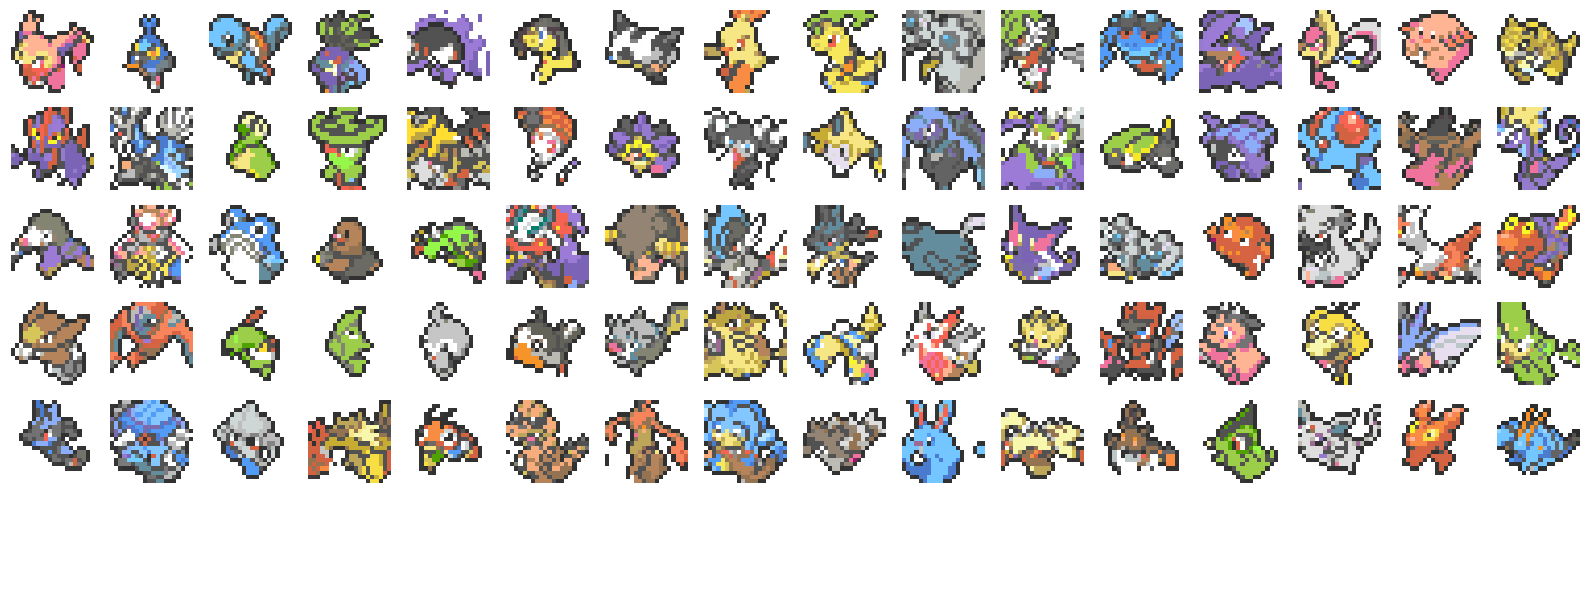

In [38]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)